In [3]:
"""
load data
"""
import sklearn.datasets
import numpy as np
import random

iris = sklearn.datasets.load_iris()
data = iris['data']
labels = iris['target']

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_matrix(x, y, group, fmt='.', **kwargs):
    """
    Given two d-dimensional datasets of n points,
    makes a figure containing d x d plots, where the (i, j) plot
    plots the ith dimension against the jth dimension.
    """

    x = np.asarray(x)
    y = np.asarray(y)
    group = np.squeeze(np.asarray(group))
    n, p = x.shape
    n_, q = y.shape
    n__, = group.shape
    assert n == n_ == n__
    groups = sorted(set(group))
    if isinstance(fmt, str):
        fmt = {k: fmt for k in groups}
    fig, axes = plt.subplots(p, q, squeeze=False, **kwargs)
    for i, axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            for g in groups:
                ax.plot(x[group == g, i], y[group == g, j], fmt[g])
            if len(axes) > 2:
                ax.locator_params(tight=True, nbins=4)

def plot_groups(x, group, fmt='.', **kwargs):
    """
    Helper function for plotting a 2-dimensional dataset with groups
    using plot_matrix.
    """
    n, d = x.shape
    assert d == 2
    x1 = x[:, 0].reshape(n, 1)
    x2 = x[:, 1].reshape(n, 1)
    plot_matrix(x1, x2, group, fmt, **kwargs)

In [278]:
def closest(data, centers):
    n, d = data.shape
    k, d_ = centers.shape
    assert d == d_
    
    rep = np.zeros(n,)
    for i in range(n):
        distance = np.sum(np.sqrt((data[i] - centers)**2), axis = 1)
        rep[i] = np.argmin(distance)
        
    assert rep.shape == (n,)
    assert np.all((0 <= rep) & (rep < k))
    rep = rep.astype('int')
    return rep


def kmeans_cost(data, centers, rep):
    n, d = data.shape
    k, d_ = centers.shape
    assert d == d_
    assert rep.shape == (n,)
    data_rep = centers[rep]
    cost = 0
    for i in range(n):
        cost += np.sum((data[i] - data_rep[i])**2)
    return cost

"""
K-means clustering algorithm
args:
D = dataset
k = number of clusters
epsilon = convergence threshold
"""

def k_means(D, k, epsilon, verbose = True):
    n,d = D.shape
    #print("start")
    """
    init random centroids
    centroids is a k,d array where element i,j is the jth value of the ith centroid
    assign each data point to a closest centroid
    recaulculate clusters as mean of all elements in cluster
    if cluster is empty, reassign randomly.
    calculate distance between new and old clusters
    if distance is smaller than epsilon, terminate
    """
    maximum = np.amax(D, axis = 0)
    minimum = np.amin(D, axis = 0)
    centers = np.zeros((k,d))
    for i in range(len(centers)):
        for j in range(d):
            centers[i,j] = random.uniform(minimum[j], maximum[j])
    old_centers = np.zeros_like(centers)
    tired = False
    
    while not tired:
        old_centers[:] = centers
        rep = closest(D, centers)
        for i in range(k):
            indices = np.where(rep == i)[0]
            if len(indices) == 0:
                   for j in range(d):
                       #print('tom')
                       centers[i,j] = random.uniform(minimum[j], maximum[j])
            else:
                centers[i] = np.sum(D[indices], axis = 0)/len(indices)
            
        dist = np.sqrt(((centers - old_centers) ** 2).sum(axis=1))
        tired = np.max(dist) <= epsilon
        cost = kmeans_cost(D, centers, rep)
        if verbose == True:
            print(cost)
    return centers, rep, cost

def k_means_opt(D, k, epsilon, n):
    centers = []
    rep = []
    cost = []
    for i in range(n):
        res = k_means(D, k, epsilon, verbose = False)
        centers.append(res[0])
        rep.append(res[1])
        cost.append(res[2])
    j = np.argmin(cost)
    return centers[j], rep[j], cost[j]

def f1(predicted, labels):
    n, = predicted.shape
    assert labels.shape == (n,)
    r = np.max(predicted) + 1
    k = np.max(labels) + 1

    # Implement the F1 score here
    contingency = np.zeros((r,k))
    for i in range(r):
        for j in range(k):
            pred = (predicted == i)
            true_label = (labels == j)
            n_correct = np.sum((true_label == pred) & (true_label))
            
            contingency[i,j] = n_correct
    precision = np.zeros(r)
    recall = np.zeros(r)
    mx = np.argmax(contingency, axis = 1)
    sm = np.sum(contingency, axis = 1)
    for i in range(r):
        precision[i] = contingency[i,mx[i]] / sm[i]
        mj = np.sum(contingency[:,mx[i]])
        recall[i] = contingency[i,mx[i]] / mj
    F_individual = ((2*precision) * recall) / (precision + recall)
    F_overall = np.mean(F_individual)

    assert contingency.shape == (r, k)
    return F_individual, F_overall, contingency


def silhouette(data, predicted):
    data = np.asarray(data)
    n, d = data.shape
    predicted = np.squeeze(np.asarray(predicted))
    k = np.max(predicted) + 1
    assert predicted.shape == (n,)

    s = np.zeros(n)
    for i in range(n):
        #Find cluster of data[i]
        assigned_cluster = predicted[i]
        #remove data[i] from temp data
        meanOut = np.zeros(k)
        for j in range(k):

            neighbors = data[(predicted == j).nonzero()]
            distance = np.zeros(len(neighbors))
            for point in range(len(neighbors)):
                distance[j] = np.sum(np.sqrt((data[i] - neighbors[j])**2))
            if j == assigned_cluster:
                meanIn = np.sum(distance) / (len(neighbors) -1)
                meanOut[j] = np.inf
            else:
                meanOut[j] = np.sum(distance) / len(neighbors)
        closest_cluster = np.argmin(meanOut)
        s[i] = (meanOut[closest_cluster] - meanIn) / (max(meanOut[closest_cluster], meanIn))
    assert s.shape == (n,)
    return np.mean(s), s

In [266]:
f1(rep, labels)


(array([ 0.8045977 ,  0.84955752,  1.        ]),
 0.88471840775777311,
 array([[  0.,   2.,  35.],
        [  0.,  48.,  15.],
        [ 50.,   0.,   0.]]))

[[ 3.418       1.464     ]
 [ 3.07179487  5.72564103]
 [ 2.7442623   4.38196721]]


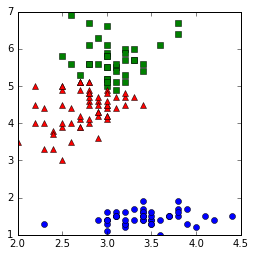

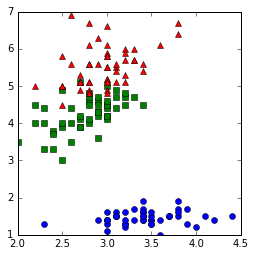

In [6]:
print(centers)
plot_groups(data_2d, rep, {0: 'o', 1: 's', 2: '^'}, figsize=(4, 4))
plot_groups(data_2d, labels, {0: 'o', 1: 's', 2: '^'}, figsize=(4, 4))


In [280]:
from scipy.stats import multivariate_normal
def pdf(points, mean, cov, prior):
    points, mean, cov = np.asarray(points), np.asarray(mean), np.asarray(cov)
    prior = np.asarray(prior)
    n, d = points.shape
    k, d_1 = mean.shape
    k_2, d_2, d_3 = cov.shape
    k_3, = prior.shape
    assert d == d_1 == d_2 == d_3
    assert k == k_2 == k_3, "%s %s %s should be equal" % (k, k_2, k_3)

    # Compute probabilities
    prob = []
    for i in range(k):
        if prior[i] < 1 / k ** 3:
            prob.append(np.zeros(n))
        else:
#            print("pdf mean ",mean[i])
#            print("pdf cov ",cov[i])
            prob.append(
                prior[i] *
                multivariate_normal.pdf(
                    mean=mean[i], cov=cov[i], x=points,allow_singular=False))
    prob = np.transpose(prob)  # n x k
    # Normalize cluster probabilities of each point
    prob = prob / np.sum(prob, axis=1, keepdims=True)  # n x k

    assert prob.shape == (n, k)
    assert np.allclose(prob.sum(axis=1), 1)
    return prob

def most_likely(points, mean, cov, prior):
    prob = pdf(points, mean, cov, prior)
    return np.argmax(prob, axis=1)

def em(points, k, epsilon, mean=None):
    points = np.asarray(points)
    n, d = points.shape

    # Initialize and validate mean
    if mean is None:
        # Randomly pick k points
        maximum = np.amax(points, axis = 0)
        minimum = np.amin(points, axis = 0)
        mean = np.zeros((k,d))
        for i in range(k):
            for j in range(d):
                mean[i,j] = np.random.uniform(minimum[j], maximum[j])

    # Validate input
    mean = np.asarray(mean)
    k_, d_ = mean.shape
    assert k == k_
    assert d == d_

    # Initialize cov, prior
    cov = np.array([np.eye(d) for x in range(k)])
    prior = np.array([1/k for x in range(k)])

    tired = False
    t = 0
    old_mean = np.zeros_like(mean)
    while not tired:
        t += 1
        old_mean[:] = mean

        # Expectation step
 #       print("--------------------------------")
 #       print("Emean ",mean)
 #       print("Ecov ",cov)
 #       print("Eprior ",prior)
        weights=pdf(points, mean, cov, prior)
 #       print ("weights ",weights)
        # Maximization step
        weights_sum=np.sum(weights,axis=0)
 #       print("sum",weights_sum)
        for i in range(k):
            res=weights[:,i].reshape(n,1)*points
            mean[i]=np.sum(res,axis=0)/weights_sum[i]
            new_cov=np.zeros([d,d])
            for j in range(n):
                new_cov+=weights[j,i]*np.outer(points[j]-mean[i],points[j]-mean[i])
            cov[i]=new_cov/weights_sum[i]
        prior[:]=weights_sum/n    
                    

        # Finish condition
        dist = np.sqrt(((mean - old_mean) ** 2).sum(axis=1))
        tired = np.all(dist < epsilon)
    #print("HURTIG")
    # Validate output
    assert mean.shape == (k, d)
    assert cov.shape == (k, d, d)
    assert prior.shape == (k,)
    #print(t)
    return mean, cov, prior



78.0822181175
69.3516540633
69.4154217997
69.4490435646
68.4210282286
66.1737621871
64.3960918146
64.7973605876
64.7973605876
Kmean clustering


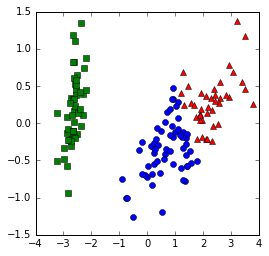

EM clustering using Kmean


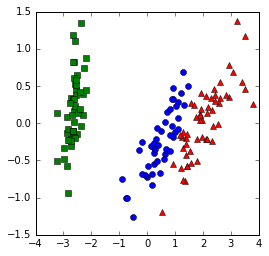

EM clustering using random init means


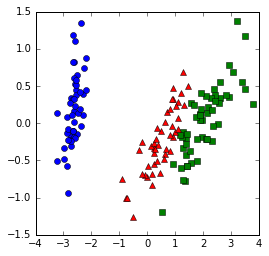

True clustering


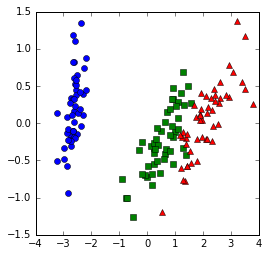

In [343]:
import sklearn.datasets
import sklearn.decomposition
pca = sklearn.decomposition.PCA(2)
data_pca = pca.fit_transform(data)

centers, rep, cost = k_means(data_pca, 3, 1e-4)
rmean1,rcov1,rprior1=em(data_pca,3,1e-04)
rmean,rcov,rprior=em(data_pca,3,1e-04,mean= centers)
cluster=most_likely(data_pca,rmean,rcov,rprior)
cluster1 = most_likely(data_pca,rmean1,rcov1,rprior1)
#############
sil_kmean = silhouette(data_pca, rep)
sil_em = silhouette(data_pca, cluster)
sil_em1 = silhouette(data_pca, cluster1)
F_kmean = f1(rep, labels)
F_em = f1(cluster, labels)
F_em1 = f1(cluster1, labels)
#############
print("Kmean clustering")
plot_groups(data_pca, rep, {0:'o',1:'s',2:'^'},figsize=(4,4))
plt.show()
print("EM clustering using Kmean")
plot_groups(data_pca,cluster,{0:'o',1:'s',2:'^'},figsize=(4,4))
plt.show()
print("EM clustering using random init means")
plot_groups(data_pca,cluster1,{0:'o',1:'s',2:'^'},figsize=(4,4))
plt.show()
print("True clustering")
plot_groups(data_pca,labels,{0:'o',1:'s',2:'^'},figsize=(4,4))


In [344]:
print("F1 kmean")
print(F_kmean[1])
print("F1 EM using kmean")
print(F_em[1])
print("F1 EM using random init")
print(F_em1[1])
print("silhouette kmean")
print(sil_kmean[0])
print("silhouette EM using kmean init")
print(sil_em[0])
print("silhouette EM using random init")
print(sil_em1[0])


F1 kmean
0.86531986532
F1 EM using kmean
0.973290598291
F1 EM using random init
0.973290598291
silhouette kmean
0.385123635829
silhouette EM using kmean init
0.368135208505
silhouette EM using random init
0.246381343281


In [349]:
# 4d data
centers, rep, cost = k_means_opt(data, 3, 1e-4, 50)
rmean1,rcov1,rprior1=em(data,3,1e-04)
rmean,rcov,rprior=em(data,3,1e-04,mean= centers)
cluster=most_likely(data,rmean,rcov,rprior)
cluster1 = most_likely(data,rmean1,rcov1,rprior1)
#############
sil_kmean = silhouette(data, rep)
sil_em = silhouette(data, cluster)
sil_em1 = silhouette(data, cluster1)
F_kmean = f1(rep, labels)
F_em = f1(cluster, labels)
F_em1 = f1(cluster1, labels)
print("F1 kmean")
print(F_kmean[1])
print("F1 EM using kmean")
print(F_em[1])
print("F1 EM using random init")
print(F_em1[1])
print("silhouette kmean")
print(sil_kmean[0])
print("silhouette EM using kmean init")
print(sil_em[0])
print("silhouette EM using random init")
print(sil_em1[0])
#############
print("Kmean clustering")
#plot_groups(data_pca, rep, {0:'o',1:'s',2:'^'},figsize=(4,4))
#plt.show()
print("EM clustering using Kmean")
#plot_groups(data_pca,cluster,{0:'o',1:'s',2:'^'},figsize=(4,4))
#plt.show()
print("EM clustering using random init means")
#plot_groups(data_pca,cluster1,{0:'o',1:'s',2:'^'},figsize=(4,4))
#plt.show()
print("True clustering")
#plot_groups(data_pca,labels,{0:'o',1:'s',2:'^'},figsize=(4,4))
#plot_matrix(data, data, cluster, {0: 'o', 1: 's', 2: '^'}, figsize = (6,6))
#plot_matrix(data, data, labels, {0: 'o', 1: 's', 2: '^'}, figsize = (6,6))
#plt.plot(range(len(sil[1])), sil[1])

F1 kmean
0.884718407758
F1 EM using kmean
0.966583124478
F1 EM using random init
0.966583124478
silhouette kmean
0.489881916602
silhouette EM using kmean init
0.28017234061
silhouette EM using random init
0.382294591884
Kmean clustering
EM clustering using Kmean
EM clustering using random init means
True clustering


In [355]:
resF = []
resSil = []
for k in range(2,8):
    centers, rep, cost = k_means_opt(data, k, 1e-4, 50)
    rmean,rcov,rprior=em(data,k,1e-04,mean= centers)
    cluster=most_likely(data,rmean,rcov,rprior)
    sil_em = silhouette(data, cluster)[0]
    F_em = f1(cluster, labels)[1]
    resF.append(F_em)
    resSil.append(sil_em)


[0.83333333333333326, 0.96658312447786132, 0.7557239756367663, 0.63969114146814932, 0.58213800028550677, 0.5219707419484142]
ssssss
[0.77343026279145288, 0.16379301232371807, 0.30678282656909567, 0.31050260509688832, 0.12119693257907622, 0.014621738610356658]


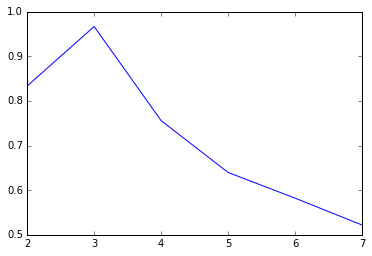

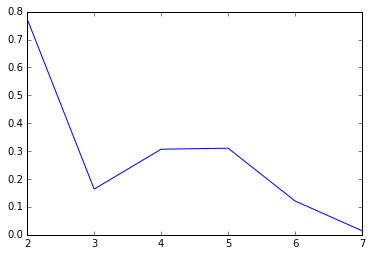

In [356]:
print(resF)
print("ssssss")
print(resSil)
plt.plot(range(2,8), resF)
plt.show()
plt.plot(range(2,8), resSil)
plt.show()

24608.4418907
13556.8305022
11044.7424685
9699.63983704
8951.90419091
8507.28771034
8228.00495845
8052.25556583
7933.75974316
7856.18573103
7804.02260721
7763.24584516
7734.67376025
7714.35866071


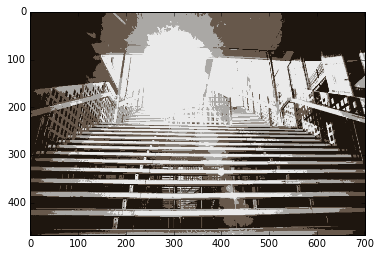

In [77]:
import scipy.misc

def download_image(url):
    filename = url[url.rindex('/')+1:]
    try:
        with open(filename, 'rb') as fp:
            return scipy.misc.imread(fp) / 255
    except FileNotFoundError:
        import urllib.request
        with open(filename, 'w+b') as fp, urllib.request.urlopen(url) as r:
            fp.write(r.read())
            return scipy.misc.imread(fp) / 255

img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
img_stairs = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_stairs.jpg')

def compress_kmeans(im, k=4):
    height, width, depth = im.shape

    data = im.reshape((height * width, depth))
    centers, rep, cost = k_means(data, k, 1e-2)
    rep = closest(data, centers)
    data_compressed = centers[rep]

    im_compressed = data_compressed.reshape((height, width, depth))
    plt.figure()
    plt.imshow(im_compressed)
    plt.show()

def compress_facade(k=4):
    img_facade = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_facade.jpg')
    compress_kmeans(img_facade, k=k)

def compress_stairs(k=4):
    img_stairs = download_image('https://users-cs.au.dk/rav/ml/handins/h4/nygaard_stairs.jpg')
    compress_kmeans(img_stairs, k=k)
    
compress_kmeans(img_stairs)

tom
tom
tom
tom
tom
tom
394.35308554
tom
tom
tom
217.810406629
178.2743416
165.19614656
155.10396799
146.706804563
141.350266008
138.032631224
136.147439574
134.102789067
132.693323855
131.260367445
130.499912633
129.568203593
128.911440061
128.225691417
127.86783061
127.623342549


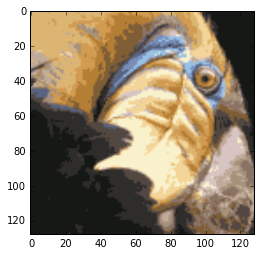

In [80]:
img_bird = download_image('https://lh3.googleusercontent.com/HtDi8G85X9kK798dfesFI0YKbQeOF_WuHM1ktqw3pNA9N-Mvx0jXoLU3qew4ykAvBafFnhJBG7uuTGg=w1301-h654')
compress_kmeans(img_bird, k = 16)